In [145]:
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from matplotlib import cm
from torch import nn, optim
from __future__ import annotations
from torch.utils.data import DataLoader, TensorDataset

from IPython.display import clear_output

import warnings

In [50]:
import kagglehub

path = kagglehub.dataset_download("bloodlaac/products-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Юля\.cache\kagglehub\datasets\bloodlaac\products-dataset\versions\1


In [51]:
warnings.filterwarnings("ignore")

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [53]:
food_dir = f"{path}\products_dataset"

FOOD = [
    'FreshApple', 'FreshBanana', 'FreshMango', 'FreshOrange', 'FreshStrawberry',
    'RottenApple', 'RottenBanana', 'RottenMango', 'RottenOrange', 'RottenStrawberry',
    'FreshBellpepper', 'FreshCarrot', 'FreshCucumber', 'FreshPotato', 'FreshTomato',
    'RottenBellpepper', 'RottenCarrot', 'RottenCucumber', 'RottenPotato', 'RottenTomato'
]

In [54]:
path = Path(food_dir)

In [55]:
class LabeledDataset():
    def __init__(self, food_dir: Path, food_classes: list[str], transform=None) -> LabeledDataset:
        self.food_dir = food_dir
        self.food_classes = food_classes
        self.transform = transform
        self.images_paths = []
        self.labels = []

        for cls_name in food_classes:
            class_path = Path(food_dir)
            class_path /= cls_name

            for image_name in class_path.iterdir():
                image_path = class_path / image_name
                self.images_paths.append(image_path)
                self.labels.append(food_classes.index(cls_name))
        
    def __len__(self) -> int:
        return len(self.images_paths)
    
    def __getitem__(self, index: int):
        image = Image.open(self.images_paths[index]).convert("RGB")
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [99]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop([200, 200]),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [100]:
food_dataset = LabeledDataset(food_dir, FOOD, transform=data_transforms)

In [58]:
trainset_len = int(0.6 * len(food_dataset))
valset_len = (len(food_dataset) - trainset_len) / 2
testset_len = len(food_dataset) - trainset_len - valset_len

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(food_dataset, [0.6, 0.2, 0.2])

In [113]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [103]:
class Block(nn.Module):
    """
    Create basic unit of ResNet.
    Consists of two convolutional layers.
    """

    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            stride: int = 1,
            downsampling=None
        ) -> Block:

        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            padding=1
        )
        self.batch_norm = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,  # TODO: Replace with padding="same"
            padding=1
        )
        self.downsampling = downsampling

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        input = x

        pred = self.batch_norm(self.conv1(x))
        pred = self.relu(pred)
        pred = self.batch_norm(self.conv2(pred))
        
        if self.downsampling is not None:
            input = self.downsampling(x)
        
        pred += input
        pred = self.relu(pred)

        return pred

In [104]:
class ResNet(nn.Module):
    """
    Build model ResNet and return prediction
    """

    def __init__(self) -> ResNet:
        super().__init__()

        self.in_channels = 64  # Default number of channels for first layer. Mutable!

        # Reduce resolution of picture by 2
        # 224 -> 112
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3
        )
        self.batch_norm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 112 -> 56

        self.layer1 = self.create_layer(out_channels=64, num_blocks=2)  # Default stride. No resolution reduction.
        self.layer2 = self.create_layer(out_channels=128, num_blocks=2, stride=2)  # Resolution reduction. 56 -> 28
        self.layer3 = self.create_layer(out_channels=256, num_blocks=2, stride=2)  # Resolution reduction. 28 -> 14
        self.layer4 = self.create_layer(out_channels=512, num_blocks=2, stride=2)  # Resolution reduction. 14 -> 7

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 20)
    
    def create_layer(
            self,
            out_channels: int,
            num_blocks: int,
            stride: int = 1
        ) -> nn.Sequential:
        """
        Create ResNet layer.

        out_channels -- number of output channels per block
        num_blocks -- number of blocks per layer
        stride -- step of filter in conv layer (default 1)
        """
        downsampling = None

        if stride != 1:
            downsampling = nn.Sequential(
                nn.Conv2d(
                    in_channels=self.in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=stride
                ),
                nn.BatchNorm2d(out_channels)
            )

        blocks: list[Block] = []
        
        blocks.append(Block(
            in_channels=self.in_channels,
            out_channels=out_channels,
            stride=stride,
            downsampling=downsampling
        ))

        self.in_channels = out_channels

        for _ in range(num_blocks - 1):
            blocks.append(Block(out_channels, out_channels))

        return nn.Sequential(*blocks)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pred = self.batch_norm(self.conv1(x))
        pred = self.relu(pred)
        pred = self.pooling(pred)

        pred = self.layer1(pred)
        pred = self.layer2(pred)
        pred = self.layer3(pred)
        pred = self.layer4(pred)

        pred = self.avgpool(pred)
        pred = torch.flatten(pred, 1)
        pred = self.fc(pred)

        return pred

In [146]:
resnet18 = ResNet().to(device)

In [ ]:
def plot_history(train_history: list, val_history: list, optimizer_name: str):
    plt.figure(figsize=(7, 5))
    plt.plot(np.arange(1, 11), train_history, label='Train')
    plt.plot(np.arange(1, 11), val_history, label='Validation')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.grid()
    plt.legend(loc='lower right')
    plt.title(f'Training {optimizer_name}')
    plt.show()

In [107]:
def validate(model, loader):
    model.eval()

    correct, total = 0, 0

    for batch in loader:
        images, labels = batch[0], batch[1]
        images = images.to('cuda')
        labels = labels.to('cuda')

        with torch.no_grad():
            pred = model(images)
        pred = torch.argmax(pred, dim=1)

        total += len(pred)
        correct += (pred == labels).cpu().numpy().sum()

    return correct / total

In [ ]:
def train(model, criterion, train_loader, val_loader, optimizer, epochs=10):
    train_acc, val_acc = [], []
    model.train()

    for epoch in range(epochs):

        correct, total = 0, 0

        for batch in train_loader:
            images, labels = batch[0], batch[1]
            images = images.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()
            pred = model(images)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

            pred = torch.argmax(pred, dim=1)

            total += len(pred)
            correct += (pred == labels).detach().cpu().numpy().sum()

        train_acc.append(correct / total)
        val_acc.append(validate(model, val_loader))

        print(f"Epoch: {epoch + 1}")
        print(f"Train accuracy: {train_acc[-1]:.4f}")
        print(f"Val accuracy: {val_acc[-1]:.4f}\n")

    return train_acc, val_acc

In [126]:
def test(model, loader):
    model.eval()

    correct, total = 0, 0

    for batch in loader:
        images, labels = batch[0], batch[1]
        images = images.to('cuda')
        labels = labels.to('cuda')

        with torch.no_grad():
            pred = model(images)
        pred = torch.argmax(pred, dim=1)

        total += len(pred)
        correct += (pred == labels).cpu().numpy().sum()

    return correct / total

In [151]:
criterion = nn.CrossEntropyLoss()

In [155]:
def get_optimizer(optimizer_name: str, model: ResNet):
    optimizers = {
        "SGD": optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
        "Adam": optim.Adam(model.parameters(), lr=0.01),
        "AdamW": optim.AdamW(model.parameters(), lr=0.01),
        "RMSprop": optim.RMSprop(model.parameters(), lr=0.01)
    }

    return optimizers[optimizer_name]

In [156]:
optimizers_names = ["SGD", "Adam", "AdamW", "RMSprop"]

Training SGD

Epoch: 1
Train accuracy: 0.3553
Val accuracy: 0.0829
Epoch: 2
Train accuracy: 0.2672
Val accuracy: 0.3771
Epoch: 3
Train accuracy: 0.4490
Val accuracy: 0.5038
Epoch: 4
Train accuracy: 0.5432
Val accuracy: 0.5875
Epoch: 5
Train accuracy: 0.6376
Val accuracy: 0.6267
Epoch: 6
Train accuracy: 0.6660
Val accuracy: 0.6992
Epoch: 7
Train accuracy: 0.7006
Val accuracy: 0.6775
Epoch: 8
Train accuracy: 0.7403
Val accuracy: 0.7408
Epoch: 9
Train accuracy: 0.7631
Val accuracy: 0.7283
Epoch: 10
Train accuracy: 0.7950
Val accuracy: 0.7812


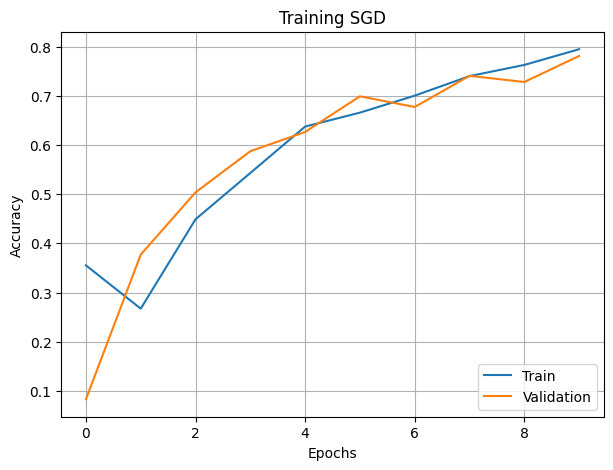

Test accuracy: 0.8579
Training Adam

Epoch: 1
Train accuracy: 0.1789
Val accuracy: 0.0912
Epoch: 2
Train accuracy: 0.2267
Val accuracy: 0.3017
Epoch: 3
Train accuracy: 0.3593
Val accuracy: 0.4342
Epoch: 4
Train accuracy: 0.4640
Val accuracy: 0.5350
Epoch: 5
Train accuracy: 0.5414
Val accuracy: 0.5663
Epoch: 6
Train accuracy: 0.6167
Val accuracy: 0.6554
Epoch: 7
Train accuracy: 0.6572
Val accuracy: 0.6571
Epoch: 8
Train accuracy: 0.7025
Val accuracy: 0.7296
Epoch: 9
Train accuracy: 0.7304
Val accuracy: 0.7196
Epoch: 10
Train accuracy: 0.7482
Val accuracy: 0.7442


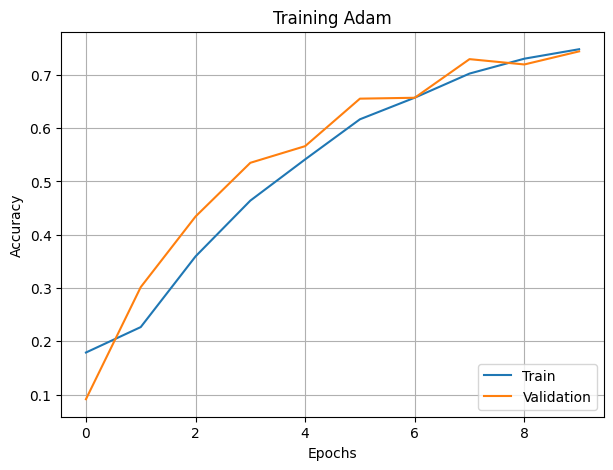

Test accuracy: 0.8488
Training AdamW

Epoch: 1
Train accuracy: 0.1949
Val accuracy: 0.1138
Epoch: 2
Train accuracy: 0.2993
Val accuracy: 0.3929
Epoch: 3
Train accuracy: 0.4418
Val accuracy: 0.4583
Epoch: 4
Train accuracy: 0.5471
Val accuracy: 0.5463
Epoch: 5
Train accuracy: 0.5919
Val accuracy: 0.5754
Epoch: 6
Train accuracy: 0.6361
Val accuracy: 0.6533
Epoch: 7
Train accuracy: 0.6919
Val accuracy: 0.7092
Epoch: 8
Train accuracy: 0.7060
Val accuracy: 0.6954
Epoch: 9
Train accuracy: 0.7326
Val accuracy: 0.7288
Epoch: 10
Train accuracy: 0.7579
Val accuracy: 0.7262


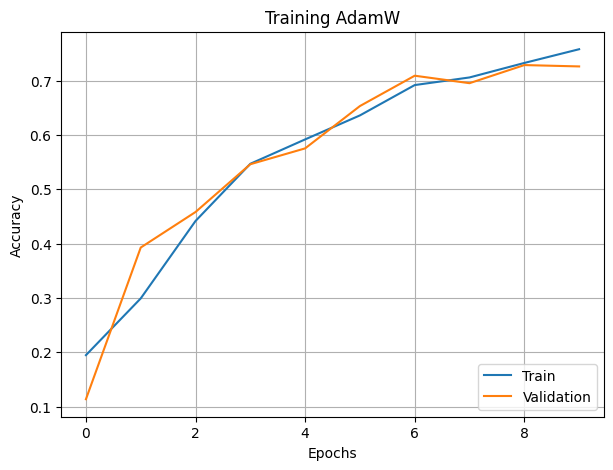

Test accuracy: 0.8542
Training RMSprop

Epoch: 1
Train accuracy: 0.1585
Val accuracy: 0.0546
Epoch: 2
Train accuracy: 0.0897
Val accuracy: 0.1454
Epoch: 3
Train accuracy: 0.1807
Val accuracy: 0.2329
Epoch: 4
Train accuracy: 0.2767
Val accuracy: 0.3446
Epoch: 5
Train accuracy: 0.3533
Val accuracy: 0.3904
Epoch: 6
Train accuracy: 0.4653
Val accuracy: 0.4537
Epoch: 7
Train accuracy: 0.5396
Val accuracy: 0.6012
Epoch: 8
Train accuracy: 0.6153
Val accuracy: 0.5650
Epoch: 9
Train accuracy: 0.6685
Val accuracy: 0.6333
Epoch: 10
Train accuracy: 0.7090
Val accuracy: 0.6421


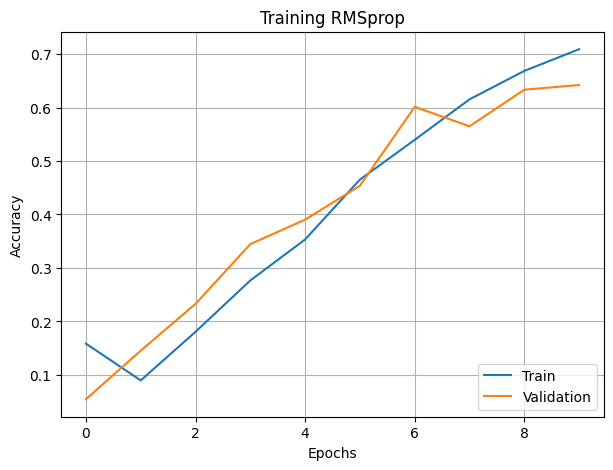

Test accuracy: 0.8450


In [157]:
for optimizer_name in optimizers_names:
    model = ResNet().to(device)
    
    print(f"Training {optimizer_name}\n")
    
    train_acc, val_acc = train(
        model,
        criterion,
        train_dataloader,
        val_dataloader,
        optimizer=get_optimizer(optimizer_name, model),
        epochs=10
    )

    plot_history(train_acc, val_acc, optimizer_name)

    test_acc = test(resnet18, test_dataloader)
    
    print(f"Test accuracy: {test_acc:.4f}")